## Most of the method that are used to decide risk tolerance of any investor are based on qualitative judgement and manual effort (risk tolerance questionaire) but investors suffer from behavioral biases and are poor judges specially in stressed markets. Also involves quite manual stuff which cannot be automated. 

## We will try to develop an ML application to build a personality profile of the client of how they will deal different market scenarios

## This notebook will try to address these 2 problems :- 

1. Train a supervised regression model to predict risk tolernace of an investor
2. Build a robo advisor dashboard (free of any human dependency) 

In [2]:
#Independent variables will be demographic, financial and behavioural attriubutes
import pandas as pd
df = pd.read_excel('SCFP2009panel.xlsx')

In [14]:
import numpy as np

In [7]:
# Risky assets are MFs, stocks and bonds
df['Risky_asset07'] = df['NMMF07'] + df['STOCKS07'] + df['BOND07']
df['Risky_asset09'] = df['NMMF09'] + df['STOCKS09'] + df['BOND09']

In [8]:
# Risk free assets are Savings, CDs and liquids
df['Risky_free07'] = df['LIQ07'] + df['CDS07'] + df['SAVBND07'] + df['CASHLI07']
df['Risky_free09'] = df['LIQ09'] + df['CDS09'] + df['SAVBND09'] + df['CASHLI09']

In [11]:
# Ratio of risky assests to total assests is riks tolerance
df['RT07'] = df['Risky_asset07']/(df['Risky_asset07']+df['Risky_free07'])

In [12]:
# stock index for normalising risky assets in 209
Average_SP500_2007=1478
Average_SP500_2009=948

In [13]:
df['RT09'] = (df['Risky_asset09']/(df['Risky_asset09']+df['Risky_free09']))*(Average_SP500_2009/Average_SP500_2007)

In [15]:
# absolute percentage change of RT
df['PerChange'] = np.abs(df['RT09']/df['RT07'] - 1) #if RT07 is zero, this will give error

In [16]:
# drop any row that contains NA
print(df.shape)
df = df.dropna(axis=0)
print(df.shape)

(19285, 522)
(9230, 522)


In [19]:
print(df.shape)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
print(df.shape)

(9230, 522)
(7956, 522)


In [39]:
# Final dataframe created
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
import warnings
warnings.filterwarnings('ignore')

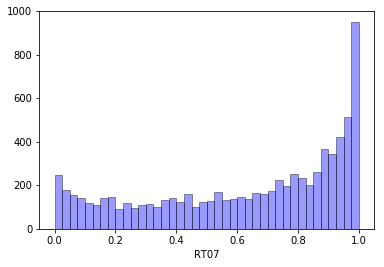

In [23]:
sns.distplot(df['RT07'], color='blue', hist=True, bins = 40, kde=False, hist_kws={'edgecolor' : 'black'})

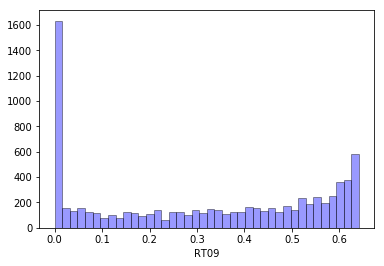

In [25]:
sns.distplot(df['RT09'], kde=False, hist=True, bins=40, color='blue', hist_kws={'edgecolor' : 'black'})

We can observer the risk tolerance shifted from close to 1 in 2007 to close to 0 in 2009 (market effect of 2008, behaviour reversed after the crisis)

Intelligent investors are those whose behaviour do not change by more than 10% (both sides)

In [33]:
df_int = df[df['PerChange'] <= 0.1]
df_int['true_risk_tolerance'] = (df_int['RT07'] + df_int['RT09']) / 2

In [34]:
# true_risk_tolerance is the predicted variable for our analysis, drop other variables
df_int = df_int.drop(labels = ['RT07', 'RT09', 'PerChange'], axis=1)

## Variables Selection

**Predictor Variable :** Age, Martial status, education, occupation, kids, spending habits ( expense > earning or vice versa), net worth, income vategory, Risk (1 being highest, 4 being lowest)

**Predicted Variable :** True risk tolerance 

In [37]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','true_risk_tolerance']
drop_list = [i for i in df_int.columns if i not in keep_list2]

In [38]:
print(df_int.shape)
df_int = df_int.drop(labels=drop_list, axis =1)
print(df_int.shape)

(355, 520)
(355, 9)


#### Always remember that if you have finding correlation matrix of a dataset, it is better to show these numbers using a heat map

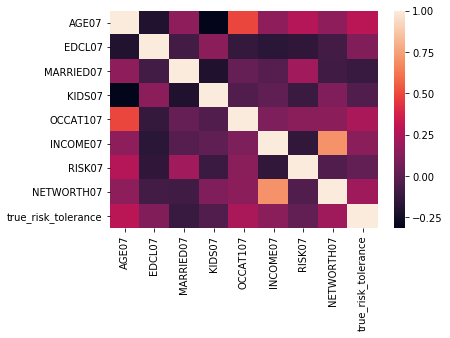

In [44]:
correlation = df_int.corr()
sns.heatmap(correlation)

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,true_risk_tolerance
AGE07,1.000000,-0.199442,0.153983,-0.314548,0.492308,0.157755,0.269954,0.156204,0.290022
EDCL07,-0.199442,1.000000,-0.078704,0.148456,-0.132615,-0.169439,-0.148950,-0.079883,0.113975
MARRIED07,0.153983,-0.078704,1.000000,-0.202003,0.031246,-0.019242,0.213488,-0.089188,-0.116096
KIDS07,-0.314548,0.148456,-0.202003,1.000000,-0.037870,0.012300,-0.114034,0.110855,-0.038783
OCCAT107,0.492308,-0.132615,0.031246,-0.037870,1.000000,0.103926,0.141213,0.146756,0.242642
INCOME07,0.157755,-0.169439,-0.019242,0.012300,0.103926,1.000000,-0.140693,0.702653,0.139044
RISK07,0.269954,-0.148950,0.213488,-0.114034,0.141213,-0.140693,1.000000,-0.041611,0.017230
NETWORTH07,0.156204,-0.079883,-0.089188,0.110855,0.146756,0.702653,-0.041611,1.000000,0.201585
true_risk_tolerance,0.290022,0.113975,-0.116096,-0.038783,0.242642,0.139044,0.017230,0.201585,1.000000
